#### Base python packages used

In [60]:
import pandas as pd
import numpy as np

from itertools import chain
import matplotlib.pyplot as plt
import os
os.chdir('C:/Data/Sentiment_Analysis')

#### Additional python packages used for text pre-processing (NLTK), scaling and metric (sklearn), Tensorflow front-end (keras)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import GRU, MaxPooling1D, Embedding
from keras.models import Model
from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [82]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

#### Read in data file, check if any na's. Copy original dataframe and work on the copy, preserving the original intact

In [6]:
posts_file = pd.read_csv('data_file.csv', index_col = 0)
posts_file.head()
posts_file.shape[0] - posts_file.dropna().shape[0]
posts_file_copy = posts_file.copy()

#### We want to see if there are in patterns in the distribution of the labels based upon the content of the posts that might become apparent during standard text pre-processing such as tokenization, removing stop word, lemmatization etc. The following cells will undertake these steps starting with tokenization immediately below. 
#### Note that though we are working on the entire file we are not stealing from the test data, so to speak, as no train metrics are being evaluated here that foresees test data. Later when we normalize numeric data or tokenize text data we fit the models on train data first and then use these estimators' transformations on test data

In [7]:
tokenized_single_posts = [nltk.tokenize.word_tokenize(i) for i in posts_file.text]
len(tokenized_single_posts)

31634

In [9]:
leng = []
for i in range(len(tokenized_single_posts)):
    length = len(tokenized_single_posts[i])
    leng.append(length)

#### Remove stop words from tokenized posts

In [10]:
stp_removed = []

for i in range (len(tokenized_single_posts)):
    stp = [word for word in tokenized_single_posts[i] if word not in stopwords.words('english')]
    stp_removed.append(stp)
    

#### Save stop removed posts in text file for possible future uses

In [8]:
# stp_removed_file = open('stp_removed_file.txt', 'w', encoding = 'UTF-8')
# for item in stp_removed:
#     stp_removed_file.write("%s\n" % item[1:-1])

In [11]:
len(stp_removed)

31634

#### Lemmatize the stop removed posts

In [12]:
words_lemma = []
lemma = nltk.WordNetLemmatizer()
for i in range(len(stp_removed)):
    words = [lemma.lemmatize(word) for word in stp_removed[i]]
    words_lemma.append(words)

In [13]:
len(words_lemma)

31634

#### Remove all digit words

In [14]:
words_noNum = []
for i in range(len(words_lemma)):
    words = [word for word in words_lemma[i] if word.isdigit() == False]
    words_noNum.append(words)

In [15]:
len(words_noNum)

31634

#### Remove single character words

In [16]:
words_nonSingle = []
for i in range(len(words_noNum)):
    words = [word for word in words_noNum[i] if len(word) > 1]
    words_nonSingle.append(words)

In [17]:
len(words_nonSingle)

31634

#### Remove non-alphabetic words

In [18]:
words_alpha = []
for i in range(len(words_nonSingle)):
    words = [word for word in words_nonSingle[i] if word.isalpha()]
    words_alpha.append(words)

In [25]:
len(words_alpha)

31634

#### Generate new column in the dataframe that is a count of words in each post after the previous pre-processing steps

In [31]:
posts_file_copy['words_count'] = [len(i) for i in words_alpha]

#### We then get the frequency distribution of nouns, verbs, adjectives and adverbs in each pre-processed post to see if there are any significant differences between these distributions based on multi-class, multi-label outcomes. A dataframe with these frequencies is joined with our working dataframe

In [20]:
noun_freq = []
verb_freq = []
adjective_freq = []
adverb_freq = []
for i in range(len(words_alpha)):
    word_pos_tag = pos_tag(words_alpha[i])
    count_noun = 0
    count_verb = 0
    count_adjective = 0
    count_adverb = 0
    for j in range(len(word_pos_tag)):
        if word_pos_tag[j][1] == "NN":
            count_noun += 1
        if word_pos_tag[j][1] == 'VB':
            count_verb += 1
        if word_pos_tag[j][1] == 'JJ':
            count_adjective += 1
        if word_pos_tag[j][1] == 'RB':
            count_adverb += 1
    noun_freq.append(count_noun/(len(words_alpha[i]) + 1))
    verb_freq.append(count_verb/(len(words_alpha[i])+1))
    adjective_freq.append(count_adjective/(len(words_alpha[i])+1))
    adverb_freq.append(count_adverb/(len(words_alpha[i])+1))

In [22]:
freq_dict = {'noun_freq' : noun_freq, 'verb_freq' : verb_freq, 'adjective_freq' : adjective_freq, 'adverb_freq' : adverb_freq}

In [27]:
posts_file_copy = posts_file_copy.join(pd.DataFrame(freq_dict))

#### Group the posts by the generated features across word count and parts of speech. In mean word count - as can be seen in the table below, there is a huge difference from just 27.5 words on average for posts that are both hate_speech and insulting to 48 words for posts that are only obscene. Similary verb_freq ranges from 2.9% on average when a post is all three of hate, obscene, insult to 4.3% when it is obscene only. The range of these feature values indicate that it would be useful to include (standardized) versions of these in our neural networks

In [30]:
features_distrbn = posts_file_copy.groupby(['hate_speech', 'obscene', 'insulting'], 
                        as_index = False)['words_count', 'adjective_freq', 'noun_freq', 'adverb_freq', 'verb_freq'].mean()
np.round(features_distrbn, 3)

,hate_speech,obscene,insulting,words_count,adjective_freq,noun_freq,adverb_freq,verb_freq
0,0,0,0,34.982,0.114,0.298,0.053,0.037
1,0,0,1,36.310,0.137,0.292,0.047,0.042
2,0,1,0,48.050,0.122,0.301,0.062,0.043
3,0,1,1,37.831,0.115,0.298,0.056,0.039
4,1,0,0,32.514,0.112,0.281,0.049,0.035
5,1,0,1,27.486,0.113,0.277,0.048,0.033
6,1,1,0,28.795,0.105,0.275,0.038,0.032
7,1,1,1,29.754,0.108,0.270,0.035,0.029


#### We now read the GLoVE 100 file for preparing an Embedding layer of 100 dimenions

In [47]:
GLOVE_DIR = 'C:/RNN/rnn_lstm_full/glove.6B'
MAX_SEQUENCE_LENGTH = 50
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

embeddings_index = {}

with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### For training our neural network we will initialize the Embedding layer with pre-trained weights from the GLoVE model:

In [32]:
## Define the sequence lengths, max number of words and embedding dimensions
MAX_SEQUENCE_LENGTH = 50   # Sequence length of each sentence. If more, crop. If less, pad with zeros
MAX_NB_WORDS = 10000        # Top 10000 frequently occuring words

#### Train-validation-test split. We separate validation data to use early stopping callback feature during training our model below

In [34]:
features = ['text', 'words_count', 'adjective_freq', 'noun_freq', 'adverb_freq', 'verb_freq']
labels = ['hate_speech', 'obscene', 'insulting']
x_train_val, x_test, y_train_val, y_test = train_test_split(posts_file_copy.loc[:,features], 
                                    posts_file_copy.loc[:,labels], test_size = 0.2, random_state = 123)

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, 
                                    y_train_val, test_size = 0.2, random_state = 123)

#### We rebuild the full training data-frame to double-check that word count and POS tagging remain useful features across the training data set as well. Note above when we analysed the test data we did not include any labels data or standardization measures, thereby strictly ensuring no leakage of test information into the trainnig space

In [37]:
train_full = pd.concat([x_train, y_train], axis = 1)

In [38]:
word_count_distrbn_train = train_full.groupby(['hate_speech', 'obscene', 'insulting'], 
        as_index = False)['words_count', 'adjective_freq', 'noun_freq', 'adverb_freq', 'verb_freq'].mean()
np.round(word_count_distrbn_train, 3)

,hate_speech,obscene,insulting,words_count,adjective_freq,noun_freq,adverb_freq,verb_freq
0,0,0,0,34.745,0.115,0.298,0.053,0.037
1,0,0,1,45.438,0.120,0.282,0.032,0.039
2,0,1,0,51.263,0.122,0.305,0.060,0.044
3,0,1,1,40.928,0.118,0.280,0.059,0.041
4,1,0,0,32.381,0.112,0.279,0.049,0.036
5,1,0,1,29.774,0.111,0.277,0.049,0.033
6,1,1,0,28.872,0.105,0.273,0.038,0.032
7,1,1,1,30.076,0.110,0.270,0.035,0.029


In [40]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(20245, 6) (5062, 6) (6327, 6)
(20245, 3) (5062, 3) (6327, 3)


#### The train-validation-test original texts are now tokenized and padded for machine-readable formatting

In [41]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)   # get the frequently occuring words
tokenizer.fit_on_texts(x_train.text)           
train_sequences = tokenizer.texts_to_sequences(x_train.text)
val_sequences = tokenizer.texts_to_sequences(x_val.text)
test_sequences = tokenizer.texts_to_sequences(x_test.text)

word_index = tokenizer.word_index               # dictionary containing words and their index
#print(tokenizer.word_index)                   # print to check
#print('Found %s unique tokens.' % len(word_index)) # total words in the corpus
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data = pad_sequences(val_sequences, maxlen = MAX_SEQUENCE_LENGTH)# get only the top frequent words on train
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)   # get only the top frequent words on test

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(20245, 50)
(5062, 50)
(6327, 50)


#### Now we standardize all the numeric features generated above by by fitting them on training data and using that to transform validation and test data respectively

In [42]:
scaleable_cols = ['words_count', 'adjective_freq', 'noun_freq', 'adverb_freq', 'verb_freq']

In [44]:
scaler_multicol = MinMaxScaler()
train_multicol_scaled = scaler_multicol.fit_transform(x_train[scaleable_cols])
val_multicol_scaled = scaler_multicol.fit_transform(x_val[scaleable_cols])
test_multicol_scaled = scaler_multicol.fit_transform(x_test[scaleable_cols])

In [45]:
train_data = np.hstack((train_data, train_multicol_scaled))
val_data = np.hstack((val_data, val_multicol_scaled))
test_data = np.hstack((test_data, test_multicol_scaled))

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(20245, 55)
(5062, 55)
(6327, 55)


#### Below we initialize the embedding matrix from GLoVE 100 which will be used as the initial weights of the Embedding layer in our neural network

In [48]:
num_words = min(MAX_NB_WORDS, len(embeddings_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### The following cell declares our final model that has:
- an initial Embedding layer with pre-trained weights from GLoVE 100 as described above, hence trainable = False at this layer,
- two layers of GRU model with in-between BatchNormalization and Dropout as mentioned, 
- the neural network uses the Keras function API and is then split after the second GRU layer into a three output model - 'hate', 'obscene', 'insult' and,
- each of the three output models have two Dense() layers as we want to visualize the learning of the network just prior to it's final predictions

In [49]:
posts_input = Input(shape=(None,), dtype='int32', name='all_posts')
embedded_posts = Embedding(input_dim=MAX_NB_WORDS,
                            input_length=MAX_SEQUENCE_LENGTH, 
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)(posts_input)

x = layers.GRU(128, activation='relu', return_sequences = True)(embedded_posts)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.GRU(64, activation = 'relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)

hate_pred = layers.Dense(8, activation = 'relu', name = 'hate0')(x)
hate_pred = layers.Dropout(0.5)(hate_pred)
hate_pred = layers.Dense(1, activation = 'sigmoid', name = 'hate')(hate_pred)

obscene_pred = layers.Dense(8, activation = 'relu', name = 'obscene0')(x)
obscene_pred = layers.Dropout(0.5)(obscene_pred)
obscene_pred = layers.Dense(1, activation = 'sigmoid',  name = 'obscene')(obscene_pred)

insult_pred = layers.Dense(8, activation = 'relu', name = 'insult0')(x)
insult_pred = layers.Dropout(0.5)(insult_pred)
insult_pred = layers.Dense(1, activation = 'sigmoid', name = 'insult')(x)

combined_model = Model(posts_input, [hate_pred, obscene_pred, insult_pred])
combined_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
all_posts (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      1000000     all_posts[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 50, 128)      87936       embedding_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 128)      512         gru_1[0][0]                      
__________________________________________________________________________________________________
dropout_1 

In [50]:
callbacks_list = [EarlyStopping(monitor='val_loss', patience=1, ),
                ModelCheckpoint(filepath='model_multi-feature.h5', monitor='val_loss',
                        save_best_only=True,)]

In [51]:
combined_model.compile(optimizer = 'rmsprop',
                      loss = {'hate' : 'binary_crossentropy',
                             'obscene' : 'binary_crossentropy',
                                 'insult' : 'binary_crossentropy'},
                      metrics = ['acc'])

In [52]:
epochs = 16
batch_size = 32

#### As mentioned above we use an Early Stopping callback while training our neural network and also save our best epoch through Checkpoint. As seen below training stops early after the third epoch as the model begins to overfit. This is not entire suprising as the number of parameters is greater than 1,000,000 while the training data size is only 20,245! We show loss and accuracy plots across epochs below and then use the saved best model for predictions and calculating weighted recall

In [53]:
hist = combined_model.fit(train_data, {'hate' : y_train['hate_speech'], 'obscene' : y_train['obscene'], 
                               'insult' : y_train['insulting']},
                                  epochs = epochs, batch_size = batch_size,
                   callbacks = callbacks_list,
               validation_data = (val_data, {'hate' : y_val['hate_speech'],                     
                       'obscene' : y_val['obscene'],   'insult' : y_val['insulting']})).history

Train on 20245 samples, validate on 5062 samples
Epoch 1/16
20245/20245 [==============================] - 87s 4ms/step - loss: 1.2432 - hate_loss: 0.4675 - obscene_loss: 0.4065 - insult_loss: 0.3692 - hate_acc: 0.7884 - obscene_acc: 0.8251 - insult_acc: 0.8286 - val_loss: 0.9294 - val_hate_loss: 0.3404 - val_obscene_loss: 0.2815 - val_insult_loss: 0.3075 - val_hate_acc: 0.8313 - val_obscene_acc: 0.8827 - val_insult_acc: 0.8564
Epoch 2/16
20245/20245 [==============================] - 87s 4ms/step - loss: 1.0255 - hate_loss: 0.3713 - obscene_loss: 0.3373 - insult_loss: 0.3168 - hate_acc: 0.8460 - obscene_acc: 0.8641 - insult_acc: 0.8543 - val_loss: 0.8850 - val_hate_loss: 0.3052 - val_obscene_loss: 0.2740 - val_insult_loss: 0.3058 - val_hate_acc: 0.8676 - val_obscene_acc: 0.8834 - val_insult_acc: 0.8572
Epoch 3/16
20245/20245 [==============================] - 86s 4ms/step - loss: 0.9693 - hate_loss: 0.3574 - obscene_loss: 0.3121 - insult_loss: 0.2998 - hate_acc: 0.8578 - obscene_acc: 

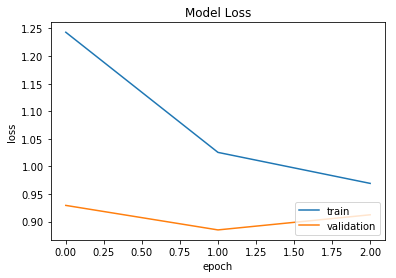

In [54]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [55]:
hate_acc = hist['hate_acc']
obscene_acc = hist['obscene_acc']
insult_acc = hist['insult_acc']
avg_acc = (pd.Series(hate_acc) + pd.Series(obscene_acc) + pd.Series(insult_acc))/3

In [56]:
hate_val_acc = hist['val_hate_acc']
obscene_val_acc = hist['val_obscene_acc']
insult_val_acc = hist['val_insult_acc']
avg_val_acc = (pd.Series(hate_val_acc) + pd.Series(obscene_val_acc) + pd.Series(insult_val_acc))/3

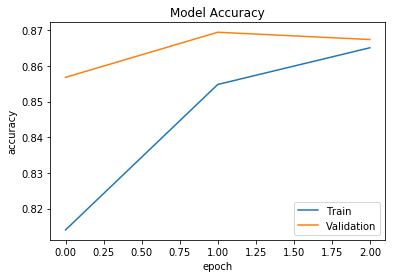

In [57]:
plt.plot(avg_acc)
plt.plot(avg_val_acc)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [58]:
model1 = load_model('model_multi-feature.h5')

In [61]:
hate_np, obscene_np, insult_np = model1.predict(test_data)

In [62]:
hate_list = list(chain.from_iterable(hate_np))
obscene_list = list(chain.from_iterable(obscene_np))
insult_list = list(chain.from_iterable(insult_np))

In [63]:
hate_pred = [1 if x >= 0.5 else 0 for x in hate_list]
obscene_pred = [1 if x >= 0.5 else 0 for x in obscene_list]
insult_pred = [1 if x >= 0.5 else 0 for x in insult_list]

In [64]:
hate_recall = recall_score(hate_pred, y_test['hate_speech'])
obscene_recall = recall_score(obscene_pred, y_test['obscene'])
insult_recall = recall_score(insult_pred, y_test['insulting'])

#### Our feature engineering has had the greatest impact on recall score of the 'insult' posts. Prior to feature engineering the insult_recall languished at  c.70% and feature engineering helped improve the true prediction rate on this class remarkably

In [65]:
print(round(hate_recall, 3))
print(round(obscene_recall, 3))
print(round(insult_recall, 3))

0.916
0.926
0.82


In [66]:
num_hate = y_train['hate_speech'].sum()
num_obscene = y_train['obscene'].sum()
num_insult = y_train['insulting'].sum()

In [67]:
f1 = num_hate/y_train.shape[0]
f2 = num_obscene/y_train.shape[0]
f3 = num_insult/y_train.shape[0]

In [68]:
w1 = 1-f1
w2 = 1-f2
w3 = 1-f3

#### Below we show Corrected_Weighted_Recall which is the evaluation metric that was finally adopted for this assignment. Just for reference we also show weighted_recall which was the initial evaluation metric that was published. Their difference shows the impact of being able to forecast the minority classes accurately

In [69]:
Corrected_Weighted_Recall = (w1*hate_recall + w2*obscene_recall + w3*insult_recall)/(3-f1-f2-f3)

In [70]:
print(round(Corrected_Weighted_Recall, 4))

0.8838


In [71]:
weighted_recall = (y_test['hate_speech'].sum()*hate_recall + y_test['obscene'].sum()*obscene_recall + 
                    y_test['insulting'].sum()*insult_recall) / (y_test.shape[0])

In [85]:
print(round(weighted_recall, 4))

0.9039


#### In summary we achieve a 88.38% weighted recall on TEST data. In earlier models without using any feature engineering we were able to achieve a weighted recall c.83%. So feature engineering has added almost 5% points to the evaluation metric. We believe this significant improvement was possible due to the small size of the training sample c.20000. Normally deep learning models are expected to learn any hidden features but due to the small sample size some basic pre-processing and feature engineering was able to add significant value in this case

#### We now seek to visualize intermediate learning in the hidden layers but freezing the model at the last-but-one layer i.e. just prior to the final forecasts. We then predict on test data using this truncated model, reduce the dimensionality of these truncated predictions from 8 to 4 via PCA and then from 4 to 2 via tSNE so that it can be visualized in 2-D space

In [73]:
trunc_posts_input = Input(shape=(None,), dtype='int32', name='all_posts')
trunc_embedded_posts = Embedding(input_dim=MAX_NB_WORDS,
                            input_length=MAX_SEQUENCE_LENGTH, 
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)(trunc_posts_input)
trunc_x = layers.GRU(128, activation='relu', return_sequences = True)(embedded_posts)
trunc_x = layers.BatchNormalization()(trunc_x)
trunc_x = layers.Dropout(0.2)(trunc_x)
trunc_x = layers.GRU(64, activation = 'relu')(trunc_x)
#x = layers.GlobalMaxPooling1D()(x)
trunc_x = layers.Dense(16, activation='relu')(trunc_x)
trunc_x = layers.Dropout(0.2)(trunc_x)

trunc_hate_pred = layers.Dense(8, activation = 'relu', name = 'trunc_hate')(trunc_x)
trunc_obscene_pred = layers.Dense(8, activation = 'relu', name = 'trunc_obscene')(trunc_x)
trunc_insult_pred = layers.Dense(8, activation = 'relu', name = 'trunc_insult')(trunc_x)
trunc_model = Model(posts_input, [trunc_hate_pred, trunc_obscene_pred, trunc_insult_pred])

In [74]:
trunc_hate_np, trunc_obscene_np, trunc_insult_np = trunc_model.predict(test_data)

In [75]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_hate = PCA(n_components=4)
pca_obscene = PCA(n_components=4)
pca_insult = PCA(n_components=4)

pca_result_hate = pca_hate.fit_transform(trunc_hate_np)
pca_result_obscene = pca_obscene.fit_transform(trunc_obscene_np)
pca_result_insult = pca_insult.fit_transform(trunc_insult_np)

print('Variance PCA hate: {}'.format(np.sum(pca_hate.explained_variance_ratio_)))
print('Variance PCA obscene: {}'.format(np.sum(pca_obscene.explained_variance_ratio_)))
print('Variance PCA insult: {}'.format(np.sum(pca_insult.explained_variance_ratio_)))

Variance PCA hate: 0.94903165102005
Variance PCA obscene: 0.9850724935531616
Variance PCA insult: 0.9928107857704163


In [76]:
tsne_hate = TSNE(n_components=2, verbose = 1)
tsne_hate_results = tsne_hate.fit_transform(pca_result_hate)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6327 samples in 0.004s...
[t-SNE] Computed neighbors for 6327 samples in 0.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6327
[t-SNE] Computed conditional probabilities for sample 2000 / 6327
[t-SNE] Computed conditional probabilities for sample 3000 / 6327
[t-SNE] Computed conditional probabilities for sample 4000 / 6327
[t-SNE] Computed conditional probabilities for sample 5000 / 6327
[t-SNE] Computed conditional probabilities for sample 6000 / 6327
[t-SNE] Computed conditional probabilities for sample 6327 / 6327
[t-SNE] Mean sigma: 0.002061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.007812
[t-SNE] Error after 1000 iterations: 1.442121


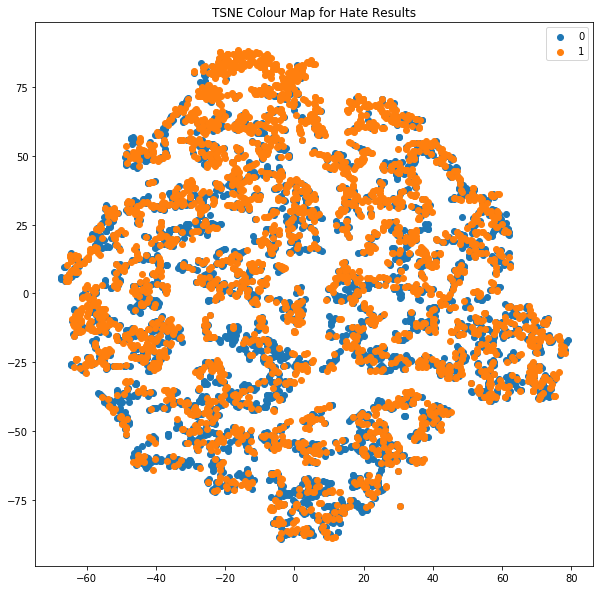

In [77]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_hate = np_utils.to_categorical(y_test['hate_speech'], num_classes = 2)
color_map = np.argmax(y_test_hate, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_hate_results[indices,0], tsne_hate_results[indices, 1], label=cl)
plt.legend()
plt.title('TSNE Colour Map for Hate Results')
plt.show()

In [78]:
tsne_obscene = TSNE(n_components=2, verbose = 1)
tsne_obscene_results = tsne_obscene.fit_transform(pca_result_obscene)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6327 samples in 0.008s...
[t-SNE] Computed neighbors for 6327 samples in 0.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6327
[t-SNE] Computed conditional probabilities for sample 2000 / 6327
[t-SNE] Computed conditional probabilities for sample 3000 / 6327
[t-SNE] Computed conditional probabilities for sample 4000 / 6327
[t-SNE] Computed conditional probabilities for sample 5000 / 6327
[t-SNE] Computed conditional probabilities for sample 6000 / 6327
[t-SNE] Computed conditional probabilities for sample 6327 / 6327
[t-SNE] Mean sigma: 0.002458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.070290
[t-SNE] Error after 1000 iterations: 1.390728


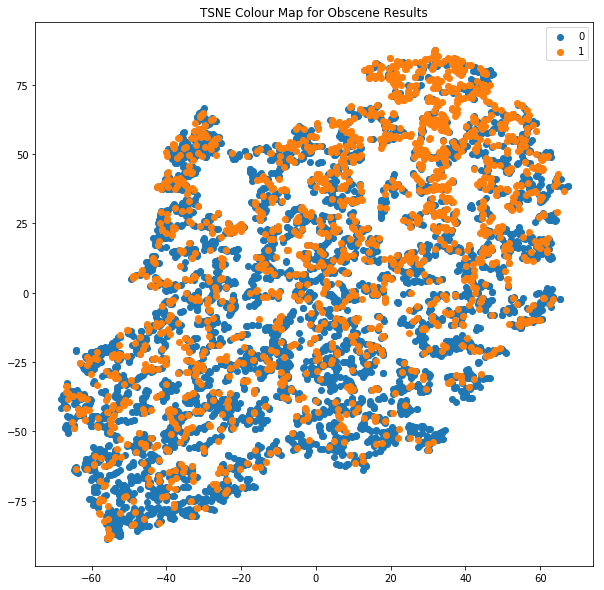

In [79]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_obscene = np_utils.to_categorical(y_test['obscene'], num_classes = 2)
color_map = np.argmax(y_test_obscene, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_obscene_results[indices,0], tsne_obscene_results[indices, 1], label=cl)
plt.legend()
plt.title('TSNE Colour Map for Obscene Results')
plt.show()

In [80]:
tsne_insult = TSNE(n_components=2, verbose = 1)
tsne_insult_results = tsne_insult.fit_transform(pca_result_insult)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6327 samples in 0.008s...
[t-SNE] Computed neighbors for 6327 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6327
[t-SNE] Computed conditional probabilities for sample 2000 / 6327
[t-SNE] Computed conditional probabilities for sample 3000 / 6327
[t-SNE] Computed conditional probabilities for sample 4000 / 6327
[t-SNE] Computed conditional probabilities for sample 5000 / 6327
[t-SNE] Computed conditional probabilities for sample 6000 / 6327
[t-SNE] Computed conditional probabilities for sample 6327 / 6327
[t-SNE] Mean sigma: 0.001647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.278214
[t-SNE] Error after 1000 iterations: 1.165311


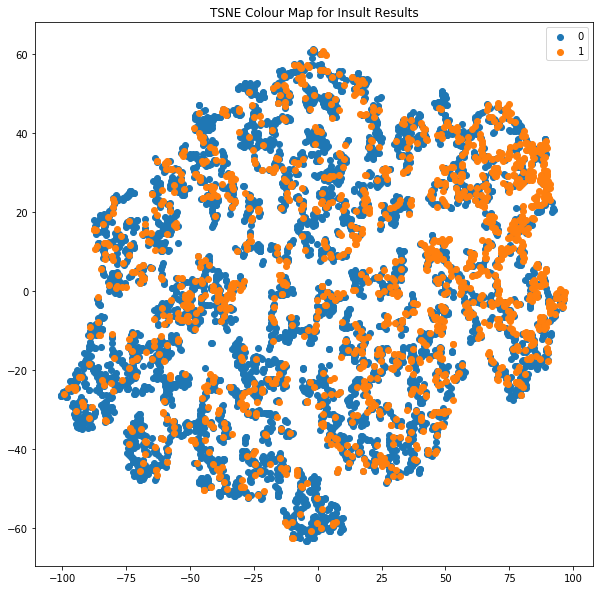

In [81]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_insult = np_utils.to_categorical(y_test['insulting'], num_classes = 2)
color_map = np.argmax(y_test_insult, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_insult_results[indices,0], tsne_insult_results[indices, 1], label=cl)
plt.legend()
plt.title('TSNE Colour Map for Insult Results')
plt.show()